# Task

Произвести сегментацию объектов стройки с применением архитектуры PSPNet


In [1]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization 
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 
from google.colab import files 
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image 
import numpy as np 
from sklearn.model_selection import train_test_split
import time
import random
import os 
from PIL import Image 

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


**Объявление глобальных параметров**



In [3]:
# Глобальные параметры
img_width = 176     # Ширина уменьшенной картинки 
img_height = 240    # Высота уменьшенной картинки 
num_classes = 8     # Задаем количество классов на изображении
directory = '/content/drive/MyDrive/DataSets/База сегментации' # Указываем путь к общей директории
train_directory = '/Тренировочная_стройка' # Название папки с файлами обучающей выборки
val_directory = '/Проверочная_стройка' # Название папки с файлами проверочной выборки

**Оригинальные изображения**

In [4]:
train_images  = [] # Список для ОРИГИНАЛЬНЫХ изображений ОБУЧАЮЩЕЙ выборки
val_images    = [] # Список для ОРИГИНАЛЬНЫХ изображений ПРОВЕРОЧНОЙ выборки

# Заполняем train_images  
cur_time = time.time()
for filename in sorted(os.listdir(f'{directory}{train_directory}/Исходники')):    
    train_images.append(image.load_img(f'{directory}{train_directory}/Исходники/{filename}',
                                       target_size=(img_width, img_height)))                                                       
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')
print ('Количество изображений: ', len(train_images)) 


# Заполняем val_images
cur_time = time.time() 
for filename in sorted(os.listdir(f'{directory}{val_directory}/Исходники')):                  
    val_images.append(image.load_img(f'{directory}{val_directory}/Исходники/{filename}', 
                                     target_size=(img_width, img_height)))     
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print ('Количество изображений: ', len(val_images)) 


Обучающая выборка загржуена. Время загрузки: 33.92c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 14.66c
Количество изображений:  50


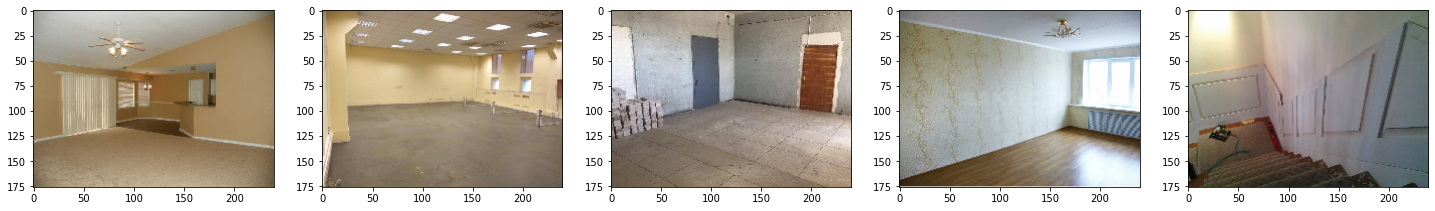

In [5]:
# Выводим ОРИГИНАЛЬНЫЕ изображения ОБУЧАЮЩЕЙ выборки 
n = 5 
fig, axs = plt.subplots(1, n, figsize=(25, 5)) 
for i in range(n): 
    img = random.choice(train_images) 
    axs[i].imshow(img) 
plt.show() 

In [6]:
fig.savefig('train_images_samples.png')

**Сегментированные изображения**

In [7]:
train_segments  = [] # Cписок СЕГМЕНТИРОВАННЫХ изображений ОБУЧАЮЩЕЙ выборки
val_segments    = [] # Список СЕГМЕНТИРОВАННЫХ изображений ПРОВЕРОЧНОЙ выборки

# Заполняем train_segments
cur_time = time.time() 
for filename in sorted(os.listdir(f'{directory}{train_directory}/Размеченные')):      
    train_segments.append(image.load_img(f'{directory}{train_directory}/Размеченные/{filename}',
                                       target_size=(img_width, img_height)))
              
print('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(train_segments)) 


# Заполняем val_segments
cur_time = time.time()  
for filename in sorted(os.listdir(f'{directory}{val_directory}/Размеченные')):
    val_segments.append(image.load_img(f'{directory}{val_directory}/Размеченные/{filename}', 
                                     target_size=(img_width, img_height)))   
print('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(val_segments)) 

Обучающая выборка загржуена. Время загрузки: 55.34c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 16.6c
Количество изображений:  50


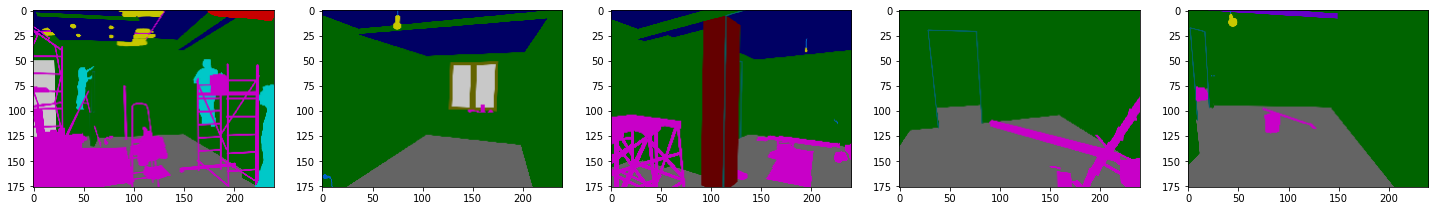

In [8]:
# Выводим СЕГМЕНТИРОВАННЫЕ изображения ОБУЧАЮЩЕЙ выборки 
n = 5 
fig, axs = plt.subplots(1, n, figsize=(25, 5))
for i in range(n): 
    img = random.choice(train_segments) 
    axs[i].imshow(img)
plt.show() 

# Predrocessing



In [9]:
####################################################################################
# Функция преобразования пикселя сегментированного изображения в индекс (8 классов).
####################################################################################

def color2index(color):
    index=-1
    if   (149>=color[0]>51)   and (149>=color[1]>=51)  and (149>=color[2]>=51)  : index=0 # пол
    elif (49>=color[0]>=0)    and (49>=color[1]>=0)    and (149>=color[2]>=51)  : index=1 # потолок
    elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (49>=color[2]>=0)    : index=2 # стена
    elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (49>=color[2]>=0)    : index=2 # колонна
    elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (149>=color[2]>=51)  : index=3 # проем
    elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (149>=color[2]>=51)  : index=3 # дверь
    elif (149>=color[0]>=51)  and (149>=color[1]>=51)  and (49>=color[2]>=0)    : index=3 # окно
    elif (249>=color[0]>=151) and (249>=color[1]>=151) and (249>=color[2]>=151) : index=3 # внешний мир
    elif (49>=color[0]>=0)    and (49>=color[1]>=51)   and (249>=color[2]>=151) : index=4 # лестница
    elif (49>=color[0]>=0)    and (249>=color[1]>=151) and (49>=color[2]>=0)    : index=4 # перила
    elif (249>=color[0]>=151) and (49>=color[1]>=0)    and (49>=color[2]>=0)    : index=4 # батарея
    elif (49>=color[0]>=0)    and (249>=color[1]>=151) and (249>=color[2]>=151) : index=5 # люди
    elif (249>=color[0]>=151) and (49>=color[1]>=0)    and (249>=color[2]>=151) : index=6 # инвентарь
    elif (249>=color[0]>=151) and (249>=color[1]>=151) and (49>=color[2]>=0)    : index=6 # источники света
    elif (49>=color[0]>=0)    and (149>=color[1]>=51)  and (249>=color[2]>=151) : index=6 # провода
    elif (149>=color[0]>=51)  and (49>=color[1]>=0)    and (249>=color[2]>=151) : index=6 # балка
    else: index=7 
    return index  

In [10]:
################################################
# Функция преобразования индекса в цвет пикселя.
################################################

def index2color(index2):
    index = np.argmax(index2) # Получаем индекс максимального элемента
    color=[]
    if   index == 0: color = [100, 100, 100]  # пол
    elif index == 1: color = [0, 0, 100]      # потолок
    elif index == 2: color = [0, 100, 0]      # стена, колонна
    elif index == 3: color = [100, 0, 0]      # проем, дверь, окно
    elif index == 4: color = [0, 100, 100]    # лестница, перила, батарея
    elif index == 5: color = [100, 0, 100]    # люди
    elif index == 6: color = [0, 0, 0]        # инвентарь, источник света, провода, балка
    elif index == 7: color = [100, 100, 0]    # что-то непонятное
    return color # Возвращаем цвет пикслея

In [11]:
#############################################################################
# Функция преобразования трехканального пикслея в to_categorical по индексу.
#############################################################################

def rgbToohe(y, num_classes): 

    y_shape = y.shape 
    y = y.reshape(y.shape[0] * y.shape[1], 3)

    yt = [] # Лист для ряда OHE
    
    # Переводим трёхканальные пиксели в индексы и преобразуем в OHE
    for i in range(len(y)): 
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) 
    
    yt = np.array(yt)
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # Решейпим к исходныму размеру

    return yt # Возвращаем сформированный массив

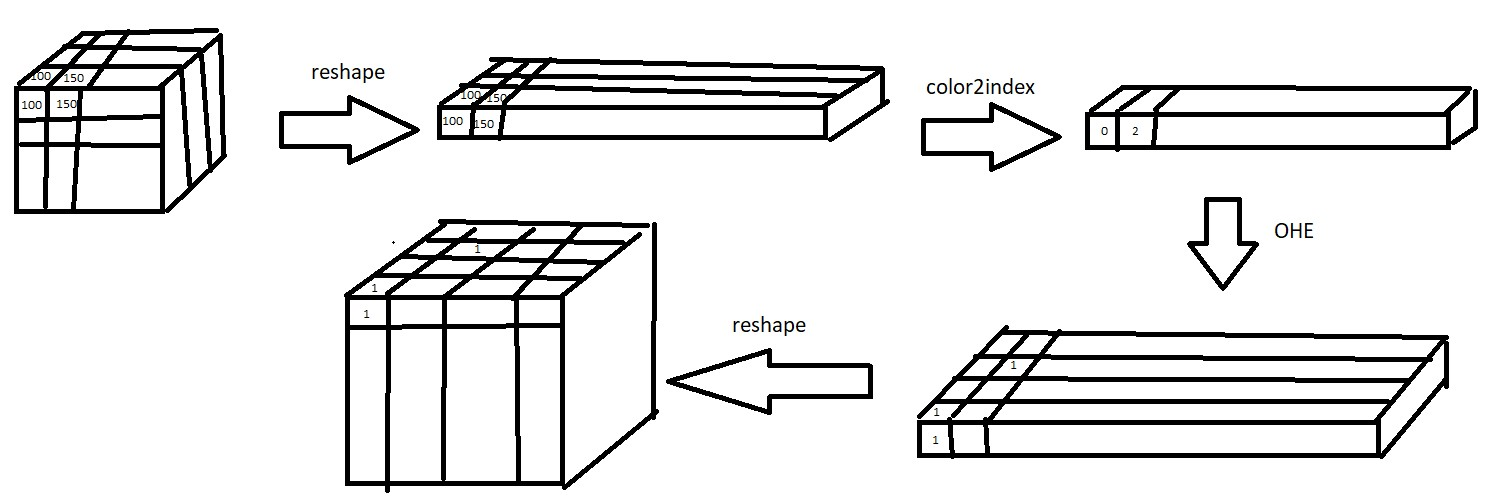# Новый раздел

In [14]:
##############################
# Функция формирования yTrain.
##############################

def yt_prep(data, num_classes):

    yTrain = []

    for seg in data:                  # Пробегаем по сегминтированными изображениями
        y = image.img_to_array(seg)   # Переводим изображение в numpy-массив 
        y = rgbToohe(y, num_classes)  # Получаем OHE-представление сформированного массива
        yTrain.append(y)              # Добавляем очередной элемент в yTrain
        if len(yTrain) % 100 == 0:    # Каждые 100 шагов
            print(len(yTrain))        # Выводим количество обработанных изображений
    return np.array(yTrain)           # Возвращаем сформированный yTrain

Формируем xTrain и xVal

In [15]:
xTrain = [] 
for img in train_images: 
    x = image.img_to_array(img)
    xTrain.append(x) 
xTrain = np.array(xTrain)

xVal = [] 
for img in val_images: 
    x = image.img_to_array(img)
    xVal.append(x) 
xVal = np.array(xVal) 

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(900, 176, 240, 3)
(50, 176, 240, 3)


Формируем yTrain

In [16]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

100
200
300
400
500
600
700
800
900
Время обработки:  2354.33 c


In [17]:
yTrain.shape

(900, 176, 240, 8)

 Формируем yVal

In [18]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

Время обработки:  123.62 c


In [19]:
yVal.shape

(50, 176, 240, 8)

# Modelling


In [20]:
####################################################
# Функция визуализации сегментированных изображений.
####################################################

def processImage(model, count = 5, n_classes = 8):

    # Получаем count случайных индексов
    indexes = np.random.randint(0, len(xVal), count)  
    fig, axs = plt.subplots(3, count, figsize=(25, 5)) 

    for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам

        predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3)))
        pr = predict[0] #  их (1, 176, 240, 8) берём (176, 240, 8)

        pr1 = [] # Лист под сегментированную картинку из predicta
        pr2 = [] # Лист под сегменитрованную картинку из yVal

        pr = pr.reshape(-1, n_classes)        # Вытягиваем предикт (h,l,n) -> (h*l,n)
        yr = yVal[idx].reshape(-1, n_classes) # Вытягиваем yVal

        for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
            pr1.append(index2color(pr[k])) # Переводим индекс в писксель
            pr2.append(index2color(yr[k])) # Переводим индекс в писксель

        pr1 = np.array(pr1) # Преобразуем в numpy
        pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        pr2 = np.array(pr2) # Преобразуем в numpy
        pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
        axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
        axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
        axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение  

    plt.show()  

In [21]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

## U-Net



In [23]:
def simpleUnet(num_classes = 6, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

  
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D


    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D
    
 
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

   
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(num_classes,(3,3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                            # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                           # Возвращаем модель

In [24]:
modelS = simpleUnet(num_classes, (img_width, img_height, 3))   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Предсказание НЕ обученной нейронки**

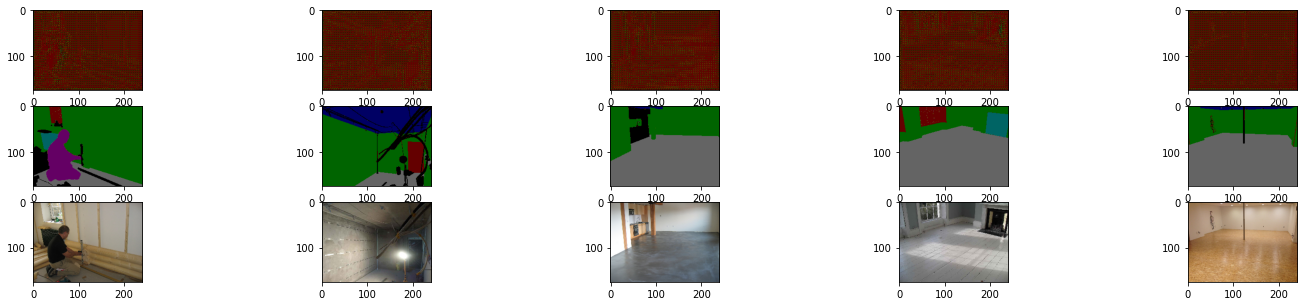

In [25]:
processImage(modelS)

In [26]:
modelS = simpleUnet(num_classes, (img_width, img_height, 3))                                                              # Создаем модель simpleUnet
history = modelS.fit(xTrain, yTrain, epochs=15, batch_size=16, validation_data = (xVal, yVal)) # Обучаем модель на выборке по трем классам

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
57/57 [==============================] - 23s 326ms/step - loss: 1.2891 - dice_coef: 0.3908 - val_loss: 1.5333 - val_dice_coef: 0.2439
Epoch 2/15
57/57 [==============================] - 17s 300ms/step - loss: 1.1178 - dice_coef: 0.4523 - val_loss: 1.3721 - val_dice_coef: 0.2925
Epoch 3/15
57/57 [==============================] - 17s 300ms/step - loss: 1.0690 - dice_coef: 0.4739 - val_loss: 1.2925 - val_dice_coef: 0.3401
Epoch 4/15
57/57 [==============================] - 17s 300ms/step - loss: 1.0249 - dice_coef: 0.4972 - val_loss: 1.1820 - val_dice_coef: 0.4361
Epoch 5/15
57/57 [==============================] - 17s 299ms/step - loss: 0.9883 - dice_coef: 0.5122 - val_loss: 1.1719 - val_dice_coef: 0.4609
Epoch 6/15
57/57 [==============================] - 17s 302ms/step - loss: 0.9648 - dice_coef: 0.5284 - val_loss: 1.2804 - val_dice_coef: 0.4234
Epoch 7/15
57/57 [==============================] - 17s 301ms/step - loss: 0.9445 - dice_coef: 0.5364 - val_loss: 1.2944 - val_dic

**Предсказание обученной нейронки**

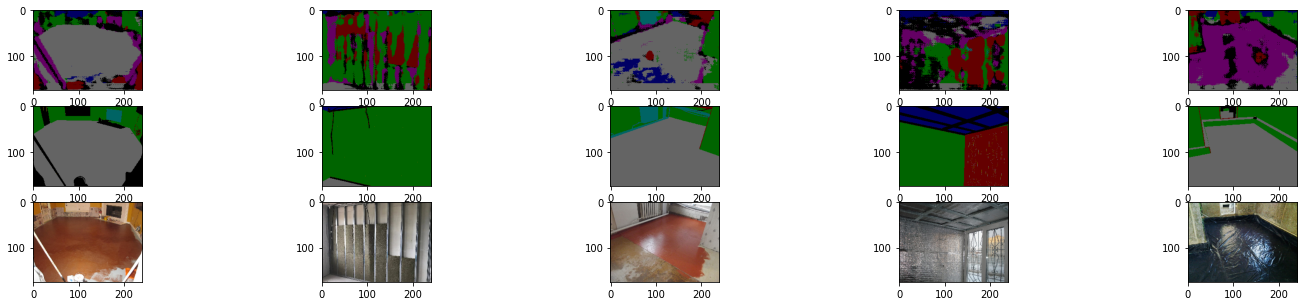

In [30]:
processImage(modelS)